# Bayesian inference via invertible neural networks

In [1]:
using Flux, DiffEqFlux, DifferentialEquations
using Flux: chunk, leakyrelu

In [2]:
ndata = randn(N).*s .+ m

UndefVarError: UndefVarError: N not defined

In [3]:
datasize = 100
s = 5.
m = 2.

tspan = (0.0f0,10f0)
x = collect(0.0:0.1:10.0)

101-element Array{Float64,1}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  1.0
  1.1
  1.2
  ⋮  
  8.9
  9.0
  9.1
  9.2
  9.3
  9.4
  9.5
  9.6
  9.7
  9.8
  9.9
 10.0

In [4]:
function inv_block(inp, out)
    s1 = Dense(inp//2, out//2, leakyrelu)
    s2 = Dense(inp//2, out//2, leakyrelu)
    t1 = Dense(inp//2, out//2, leakyrelu)
    t2 = Dense(inp//2, out//2, leakyrelu)
    
    function f(x)
        xs = chunk(x, 2) 
        v1 = xs[1] .* exp.(s2(xs[1])) + t2(xs[2])
        v2 = xs[2] .* exp.(s1(v1)) + t1(v1)          
        return vcat(v1, v2)
    end
end

inv_block (generic function with 1 method)

In [5]:
logfx(x) = (x .- m).^2 ./ s^2
dudx(x) = -x.^2 ./ 2

dudx (generic function with 1 method)

In [6]:
D = 50
dFdt = Chain(Dense(1, D), Dense(D, 1))
n_ode(x) = neural_ode(dFdt, x, tspan, Tsit5(), saveat=0.1, reltol=1e-7, abstol=1e-9)

n_ode (generic function with 1 method)

In [7]:
ps = Flux.params(dFdt)

Params([Float32[-0.0800767; -0.332212; … ; -0.266853; -0.174181] (tracked), Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (tracked), Float32[0.17269 0.00703886 … 0.0529437 -0.320592] (tracked), Float32[0.0] (tracked)])

In [8]:
f0 = [0.0]
function predict_n_ode()
  n_ode(f0)
end

predict_n_ode (generic function with 1 method)

In [9]:
dFdt([0.0])

Tracked 1-element Array{Float32,1}:
 0.0f0

In [19]:
logfx(x)

101-element Array{Float64,1}:
 0.16                
 0.1444              
 0.12960000000000002 
 0.11559999999999998 
 0.10240000000000002 
 0.09                
 0.07839999999999998 
 0.06760000000000001 
 0.0576              
 0.048400000000000006
 0.04                
 0.03239999999999999 
 0.025600000000000005
 ⋮                   
 1.9044000000000003  
 1.96                
 2.0164              
 2.0735999999999994  
 2.1316000000000006  
 2.1904000000000003  
 2.25                
 2.3104              
 2.3715999999999995  
 2.4336              
 2.4964              
 2.56                

In [11]:
loss_n_ode() = sum(abs2, (logfx(x) / dudx(x)) .-  predict_n_ode())

loss_n_ode (generic function with 1 method)

In [12]:
loss_n_ode()

0.0021123849710817507 (tracked)

In [13]:
opt = ADAM(0.1)
data = Iterators.repeated((), 100)
Flux.train!(loss_n_ode, ps, data, opt)

In [14]:
display(loss_n_ode())

7251.233494565905 (tracked)

In [17]:
cb = function () # callback function to observe training
  display(loss_n_ode())
  # plot current prediction against data
  cur_pred = Flux.data(predict_n_ode())
  pl = scatter(t,data[1,:], label="data")
  scatter!(pl,t,cur_pred[1,:], label="prediction")
  display(plot(pl))
end

#6 (generic function with 1 method)

In [20]:
cur_pred = Flux.data(predict_n_ode())

1×101 Array{Float64,2}:
 0.0  0.0617754  0.119572  0.173645  …  0.957648  0.957739  0.957823

In [32]:
using Distributions

In [34]:
d = Normal(m, s)

Normal{Float64}(μ=2.0, σ=5.0)

In [46]:
raw_data = cdf(Normal(m, s), x)

┌ Warning: `cdf(d::UnivariateDistribution, X::AbstractArray)` is deprecated, use `cdf.(d, X)` instead.
│   caller = top-level scope at In[46]:1
└ @ Core In[46]:1


101-element Array{Float64,1}:
 0.3445782583896758 
 0.3519727075758372 
 0.35942356678200876
 0.36692826396397193
 0.37448416527667994
 0.3820885778110474 
 0.3897387524442028 
 0.3974318867982395 
 0.40516512830220414
 0.4129355773517854 
 0.42074029056089696
 0.4285762840990993 
 0.4364405371085672 
 ⋮                  
 0.9162066775849858 
 0.919243340766229  
 0.9221961594734536 
 0.925066300465673  
 0.9278549630341062 
 0.9305633766666683 
 0.9331927987311419 
 0.9357445121810641 
 0.9382198232881881 
 0.940620059405207  
 0.9429465667622459 
 0.9452007083004421 

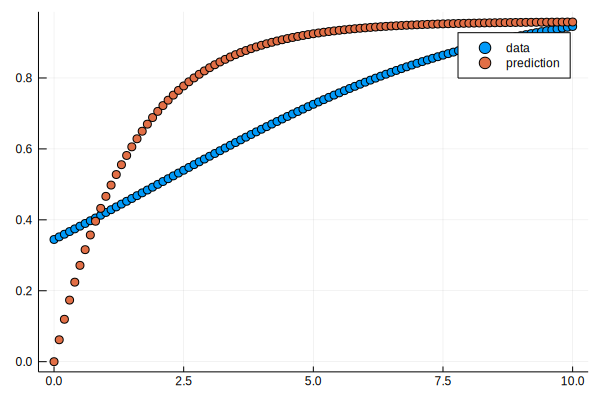

In [47]:
using Plots

pl = scatter(x, raw_data, label="data")
scatter!(pl, x, cur_pred[1,:], label="prediction")